<a href="https://colab.research.google.com/github/jean-johnson-zwix/minst_classification/blob/main/OpenCVBootcamp_MNISTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Classification using Feedforward Networks in Keras**



*   Classify hand-written digits from the MNIST dataset using a feed-forward Multilayer Perceptron Network
*   MNIST hand-written digit dataset is included in Tensorflow
*   Work with image data and build a network that classifies digits [0,9]






In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["image.cmap"] = "gray"

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

**Load and Split the MNIST Dataset**

The MNIST dataset contains 70,000 images partitioned into 60,000 for training and 10,000 for test. Reserving a portion of the data for validation can be accomplished by further partitioning the training data. As shown below, we carve out 10,000 samples from the training data to use for validation.

In [4]:
(X_train_all, y_train_all), (X_test, y_test) = mnist.load_data()

X_valid = X_train_all[:10000]
X_train = X_train_all[10000:]

y_valid = y_train_all[:10000]
y_train = y_train_all[10000:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


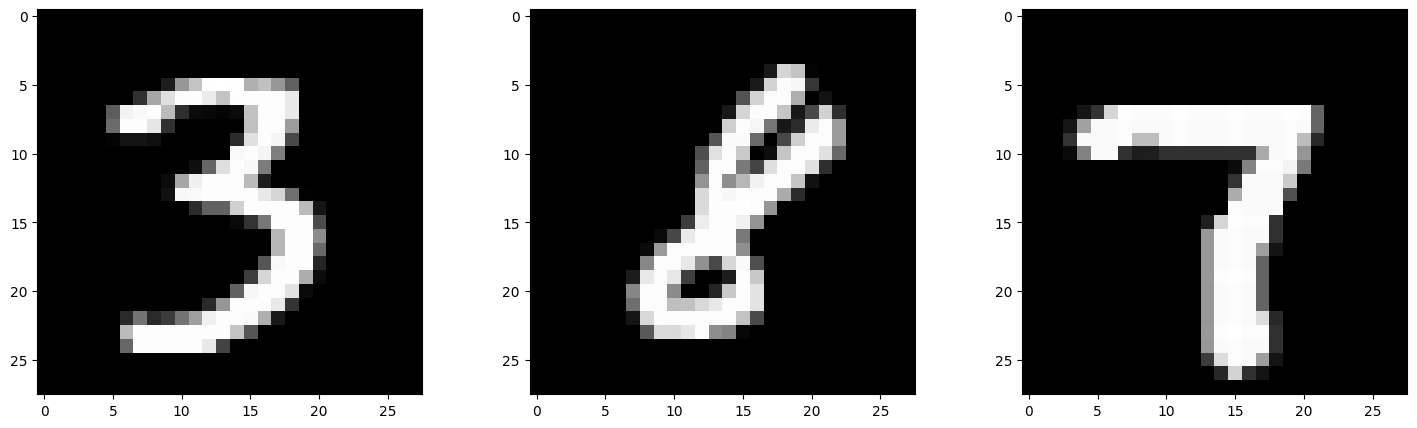

In [5]:
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.axis(True)
    plt.imshow(X_train[i], cmap="gray")
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

**DATASET PREPROCESSING**

**Input Feature Transformation and Normalization**


*   Since we are now working with images as the input, we need to find some logical way to represent the image data as a set of features
*   Assume that the pixel intensities are the features.
*   Transform the image data into a set of features that we can process by flattening the 2D array into a 1D array
*   The 28x28 input image thus becomes a 1D array containing 784 features
*   Normalize the pixel intensities to be in the range [0, 1]. This helps model to train more efficiently when working with image data.







In [6]:
X_train = X_train.reshape((X_train.shape[0], 28 * 28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28 * 28))
X_test = X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28 * 28))
X_valid = X_valid.astype("float32") / 255

**Label Encoding Options**

*   When working with categorical data, the target labels need to be represented as numerical values prior to processing the data
*   Label encoding is the process of converting class labels from strings to numerical values.
      1.   Ordinal integer encoding:
         *   Unique integer is assigned to each class
      2.   One-hot encoding:
          *   uses a separate binary vector to encode each class label (most used)
          *   It is used when class lavels have no relationship to one another
          *   Each label is converted to a binary vector where the length of the vector is equal to the number of classes. All entries are set to zero except for the element that corresponds to the integer label.











In [7]:
# INTEGER LABEL ENCODING
'''
Label   Description
0       T-shirt/top
1       Trouser
2       Pullover
3       Dress
4       Coat
5       Sandal
6       Shirt
7       Sneaker
8       Bag
9       Ankle boot
'''

# Load the Fashion MNIST dataset.
((X_train_fashion, y_train_fashion), (_, _)) = fashion_mnist.load_data()

# The labels in the Fashion MNIST dataset are encoded as integers.
print(y_train_fashion[0:9])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[9 0 0 3 0 2 7 2 5]


In [8]:
# ONE-HOT ENCODING

y_train_onehot = to_categorical(y_train_fashion[0:9])
print(y_train_onehot)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [9]:
# Convert integer labels to one-hot encoded vectors.
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test  = to_categorical(y_test)

**DEEP NEURAL NETWORK ARCHITECTURE**

The model has multiple layers:

1.   An input layer
  *    Image input data is pre-processed (flattened) from a 2-Dimensional array [28x28] to 1-Dimensional vector of length [784x1]
  *    The elements in this input vector are the normalized pixel intensities

2.   Two Hidden Layers
  *   Each contain some number of neurons (that we need to specify)
  *   Each neurons has  non-linear activation function (e.g., ReLU, Sigmoid, etc...)
3.   An output layer
  *   Ten neurons in the output layer to represent the ten different classes (digits: 0 to 9)

All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer

The values from each of the neurons in the output layer are pased through a **Softmax Function** to produce a probability score for each of the ten digits in the dataset.

Predicting the class label simply requires passing output vector through the argmax function to determine the index of the predicted label.

The loss function used is **Cross Entropy Loss**, which is generally the preferred loss function for classification problems.

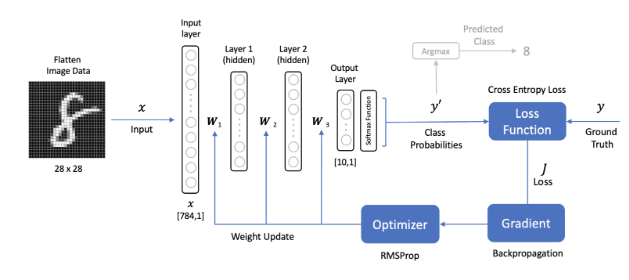



**MODEL IMPLEMENTATION**

*  two dense layers (each with 128 neurons) and a single output layer with 10 neurons.
*  Each neuron in the output layer corresponds to a class label from the dataset (0 through 9)
*   Output of each neuron represents the probability that the input image corresponds to the class associated with that neuron
*   First hidden layer has an input shape of [784,1] since the 28x28 image is flattened to a vector of length 784.
*   The neurons in each of the hidden layers have activation functions called "ReLU" which stands for Rectified Linear Unit.
*   The neurons in the output layer are then passed through a "softmax" function which transforms (normalizes) the raw output, which can be interpreted as a probability


In [10]:
# Instantiate the model.
model = tf.keras.Sequential()

# Build the model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

# Display the model summary.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

**COMPILE THE MODEL**

*  Define the optmizer
  *  RMSProp optimizer in Keras
*  Define the loss function
  *   Cross Entropy
  *   If the labels are one-hot encoded, then you should specify the loss function as categorical_crossentropy
  *   if the labels are integer encoded, then you should use sparse_categorical_crossentropy
  *   When performing binary classification, you should use binary_crossentropy.
*  Specify additional metrics to track.
  *   accuracy as the additional metric to record.



In [11]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

**TRAIN THE MODEL**

We use fit() method in Keras.

In [12]:
training_results = model.fit(X_train,
                             y_train,
                             epochs=21,
                             batch_size=64,
                             validation_data=(X_valid, y_valid));

Epoch 1/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8643 - loss: 0.4780 - val_accuracy: 0.9450 - val_loss: 0.1755
Epoch 2/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9601 - loss: 0.1360 - val_accuracy: 0.9606 - val_loss: 0.1299
Epoch 3/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9746 - loss: 0.0894 - val_accuracy: 0.9657 - val_loss: 0.1118
Epoch 4/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9818 - loss: 0.0651 - val_accuracy: 0.9684 - val_loss: 0.1100
Epoch 5/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9866 - loss: 0.0491 - val_accuracy: 0.9713 - val_loss: 0.1102
Epoch 6/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9899 - loss: 0.0377 - val_accuracy: 0.9719 - val_loss: 0.1151
Epoch 7/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9927 - loss: 0.0293 - val_accuracy: 0.9714 - val_loss: 0.1276
Epoch 8/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9937 - loss: 0.0232 - val_accuracy: 0.

**PLOT THE TRAINING RESULT**

Convenience function to plot training and validation losses and training and validation accuracies. It has a single required argument which is a list of metrics to plot.

In [13]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 20])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

The loss and accuracy metrics can be accessed from the history object returned from the fit method. We access the metrics using predefined dictionary keys as shown below.

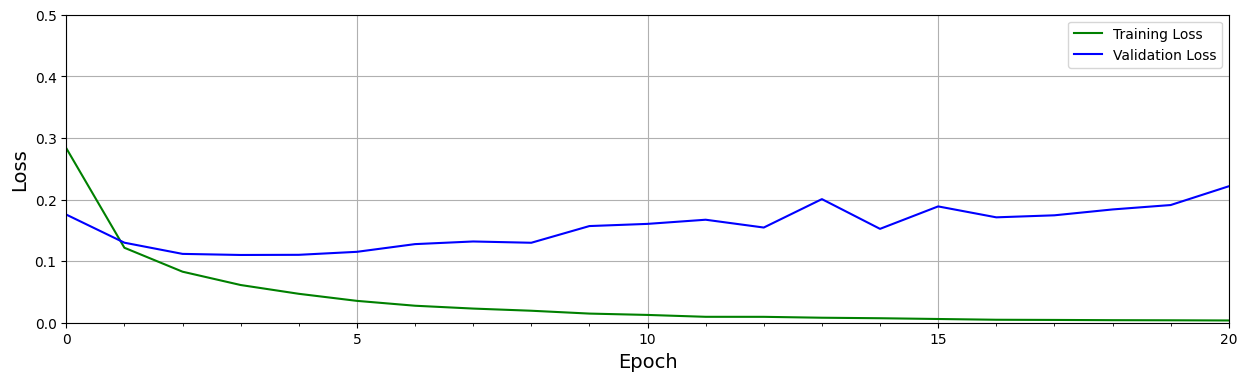

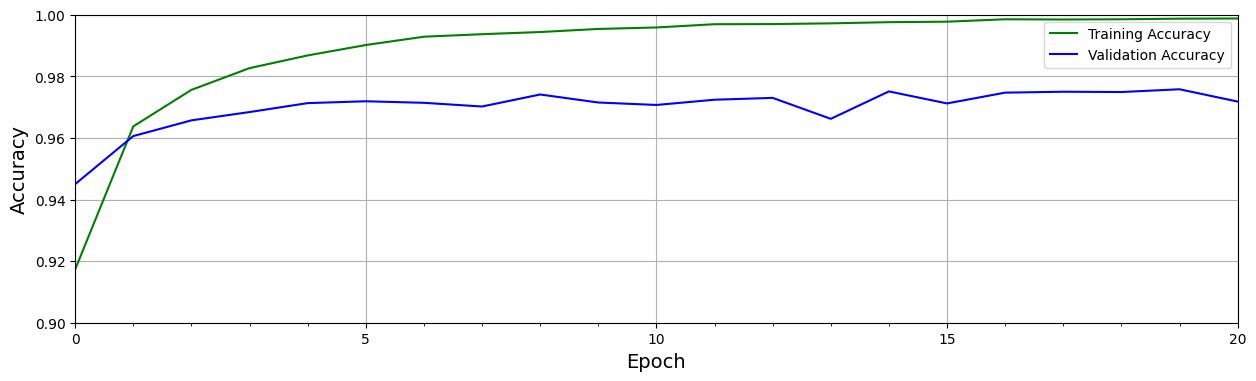

In [14]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 0.5],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.9, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

**Make Predictions on Sample Test Images**

We can now predict the results for all the test images, as shown in the code below. Here, we call the predict() method to retrieve all the predictions, and then we select a specific index from the test set and print out the predicted scores for each class. You can experiment with the code below by setting the test index to various values and see how the highest score is usually associated with the correct value indicated by the ground truth.

In [15]:
predictions = model.predict(X_test)
index = 0  # up to 9999
print("Ground truth for test digit: ", y_test[index])
print("\n")
print("Predictions for each class:\n")
for i in range(10):
    print("digit:", i, " probability: ", predictions[index][i])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Ground truth for test digit:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Predictions for each class:

digit: 0  probability:  9.023735e-25
digit: 1  probability:  2.3076376e-21
digit: 2  probability:  6.1876e-16
digit: 3  probability:  2.060251e-15
digit: 4  probability:  6.840607e-26
digit: 5  probability:  3.807431e-25
digit: 6  probability:  1.2105567e-33
digit: 7  probability:  0.99999994
digit: 8  probability:  1.3338257e-23
digit: 9  probability:  1.4317126e-15


**Confusion Matrix**

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix in TensorFlow is accomplished by calling the function tf.math.confusion_matrix(), which takes two required arguments which are the list of ground truth labels and the associated predicted lables.

In [16]:
# Generate predictions for the test dataset.
predictions = model.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


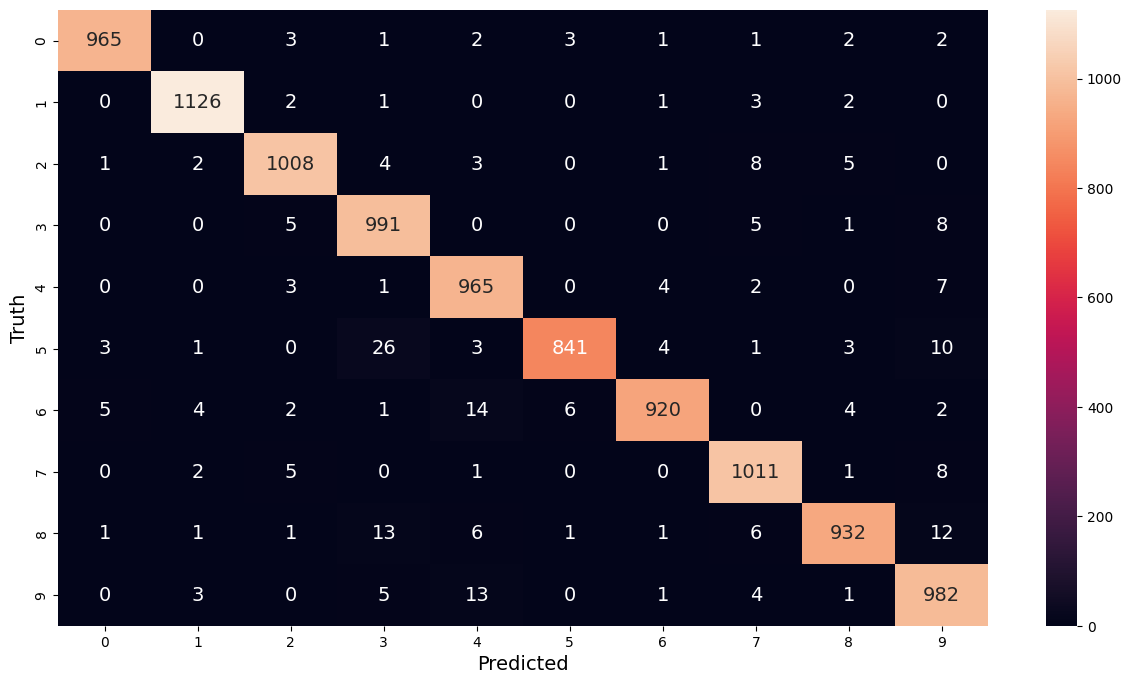

In [17]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn

sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

The following link contains a really nice interactive web-based animation of several well-known CNN architectures, which is a great place to start getting familiar with them.

https://tensorspace.org/html/playground/lenet.html